# <b> Pipeline 1 </b>
___

<b> Table of Content: </b>
<br> [0. Loading Modules and Dataset](#0)
<br> [1. Outlier IQR](#1)
<br> [2, Normalization](#2)
<br> [3. Standardization Z-score](#3)
<br> [4. Correlation Analysis](#4)
<br> [5. Binning](#5)
<br> [6. Feature Selection](#6)
<br> [7. Save Top Features and Target to a CSV File](#7)

<a id = "0"> <h2> 0. Loading Modules and Dataset </h2> </a>
___

<b> Import modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import kurtosis, skew
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import warnings

<b> Read previously recoded/calculated features from a .csv file to a pandas dataframe

In [2]:
df = pd.read_csv("df_calculation.csv")

In [3]:
# show the list of features incl. target in dataset
#df.columns.to_series().groupby(df.dtypes).groups

<a id = "1"> <h2> 1. Outlier IQR </h2> </a>
___

<b> Assumption: </b> Every data point for every continuous feature that is 1.5 times below/above the Interquartile Range (Q3-Q1) is considered an outlier
<br> Whereby zero's are excluded from the calculation of the 25% quantile and 75% quantile

The features in the table above, should not be included in dealing with outliers with the IQR method, it will result in all zero's

<b> 1.1 Create a function to deal with outliers </b>

In [4]:
def remove_cols_outliers_iqr(df, column_list): 
    for my_col in column_list:      
        # only calculate the quantile on non-zero values in the column
        Q1 = df[df[my_col] > 0 ][my_col].quantile(0.25)
        Q3 = df[df[my_col] > 0 ][my_col].quantile(0.75)
        #Q1 = df[my_col].quantile(0.25)
        #Q3 = df[my_col].quantile(0.75)
        IQR = Q3 - Q1

        u_bound_q3 = (Q3 + 1.5 * IQR)
        l_bound_q1 = (Q1 - 1.5 * IQR)
        
        # combine old column name with a suffix for the new name of the column
        suffix = '_iqr'
        my_new_col = ''.join([my_col, suffix])
        
        # create a new column with the name: (column name + suffix)
        df[my_new_col] = df[my_col]
        
        # if a value in the column is larger than the upper bound, set it equal to the upper bound, else keep the original value
        df[my_new_col] = np.where(df[my_new_col] > u_bound_q3, u_bound_q3, df[my_new_col]) 
        # if a value in the column is larger than the lower bound, set it equal to the lower bound, else keep the original value
        df[my_new_col] = np.where(df[my_new_col] < l_bound_q1, l_bound_q1, df[my_new_col]) 

<b> 1.2 Apply the function  on continuous features </b>

In [5]:
# create a list of the continuous features in the pandas dataframe
lst_continuous_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 
    'avg_exit_bounce_rates', 'add_exit_bounce_rates', 'div_exit_bounce_rates', 'perc_exit_bounce_rates', 
    'Administrative_Duration_pp', 'Informational_Duration_pp', 'ProductRelated_Duration_pp']

# apply the function to the list of continuous features        
remove_cols_outliers_iqr(df=df, column_list=lst_continuous_cols) 

<b> 1.3 Test if the function correctly worked, using different examples </b>

_test if the maximum changed_

In [6]:
print('maximum value of feature `Administrative`:', df['Administrative'].max())
print('new maximum value after removal of outliers with iqr of feature `Administrative_iqr`:', df['Administrative_iqr'].max())

maximum value of feature `Administrative`: 27
new maximum value after removal of outliers with iqr of feature `Administrative_iqr`: 12.0


In [7]:
# show the original feature versus the feature where outliers are dealt with using IQR
df[df['Administrative_iqr']==12][['Administrative', 'Administrative_iqr']].head()

,Administrative,Administrative_iqr
62,12,12.0
248,16,12.0
282,13,12.0
478,13,12.0
502,18,12.0


_Test if the number of values above and equal to the upper bound in the original feature,
<br> after imputing outliers with iqr, are the same number of values now equal to the upper bound of the adjusted feature (with iqr suffix in the column name)._

In [8]:
Q1 = df[df['Administrative'] > 0 ]['Administrative'].quantile(0.25)
Q3 = df[df['Administrative'] > 0 ]['Administrative'].quantile(0.75)
IQR = Q3 - Q1

u_bound_q3 = (Q3 + 1.5 * IQR)
l_bound_q1 = (Q1 - 1.5 * IQR)
#print(' IQR:', IQR,'\n','Upper bound:', u_bound_q3,'\n','Lower bound:',l_bound_q1)

print('Number of values above the upper bound of feature `Administrative`:', df[df['Administrative']>u_bound_q3]['Administrative'].count())
print('Number of values equal to the upper bound of feature `Administrative`:', df[df['Administrative']==u_bound_q3]['Administrative'].count())
print('Number of values below the lower bound `Administrative`:', df[df['Administrative']<=l_bound_q1]['Administrative'].count())

Number of values above the upper bound of feature `Administrative`: 213
Number of values equal to the upper bound of feature `Administrative`: 86
Number of values below the lower bound `Administrative`: 0


In [9]:
print('Number of values equal to the upper bound:', df[df['Administrative_iqr']==12]['Administrative_iqr'].count())
# test if number of values above the upper bound + equal to upper bound are the same as the total values in the feature after outlier iqr handling that are equal to the upper bound
#(213+86) = 299

Number of values equal to the upper bound: 299


_test if all iqr columns were created:_

In [10]:
# source: https://stackoverflow.com/questions/21285380/find-column-whose-name-contains-a-specific-string
iqr_cols = [col for col in df.columns if 'iqr' in col]

# test if the length of the list of columns that has iqr in the name, is the same length as the list provided in the function of column names
len(lst_continuous_cols) == len(iqr_cols)

# show columns where names contains the string 'iqr'
iqr_cols

['Administrative_iqr',
 'Administrative_Duration_iqr',
 'Informational_iqr',
 'Informational_Duration_iqr',
 'ProductRelated_iqr',
 'ProductRelated_Duration_iqr',
 'BounceRates_iqr',
 'ExitRates_iqr',
 'PageValues_iqr',
 'avg_exit_bounce_rates_iqr',
 'add_exit_bounce_rates_iqr',
 'div_exit_bounce_rates_iqr',
 'perc_exit_bounce_rates_iqr',
 'Administrative_Duration_pp_iqr',
 'Informational_Duration_pp_iqr',
 'ProductRelated_Duration_pp_iqr']

<a id = "2"> <h2> 2. Normalization </h2> </a>
___

Assumption: the dataset follows a Gaussian Distribution

<b> 2.1 Test features in dataframe if they have a minimum smaller than zero

In [11]:
df_min = df[list(df.columns)].min() > 0

# show all rows of the dataframe
#pd.set_option('display.max_rows', len(df))
# reset the option to display not all rows and truncate
#pd.reset_option('display.max_rows')
#df_min[df_min == True]

print('No minima of the features are larger than zero. Boxcox can only be applied on features with all positive values')
print('Conclusion: on all features the yeojohnson powertransform will be applied (and saved as a new column with a suffix _yj).')

# show columns where condition is False (<=0)
df_min[df_min == True]

No minima of the features are larger than zero. Boxcox can only be applied on features with all positive values
Conclusion: on all features the yeojohnson powertransform will be applied (and saved as a new column with a suffix _yj).


Series([], dtype: bool)

<b> 2.2 Create a function to normalize continuous features with a PowerTransform: </b>
<br> using Boxcox _(for Positive Features)_ or Yeojohnson (for Positive and/or Negative Features)
<br> <b> Note: </b> A power transformation will change the distribution of the data, for more information see: [link](https://medium.com/@patricklcavins/using-scipys-powertransformer-3e2b792fd712)

In [12]:
################################################################################################ 
# defined a function to normalize a feature in an additional new column with powertransform, 
# using boxcox (if positive values) or yeojohnson (if zero or negative values)
# and add a suffix to the name of the column _bc for boxcox and _yj for yeojohnson
################################################################################################ 
# required modules -> imported at the start but if you copy/paste this function please make sure you install the two below!
#from scipy.stats import boxcox
#from scipy.stats import yeojohnson

def powertransform_boxcox_yeojohnson(df, column_list):
    # loop through each column in the column list
    for my_col in column_list:      
        # test if the minimum in the column is positive, if True apply boxcox, if False apply yeojohnson
        if (df[my_col].min() > 0)==True:
            # combine old column name with a suffix for the new name of the column
            suffix = '_bc'
            my_new_col = ''.join([my_col, suffix])
            # create a new column with the name: (column name + suffix)
            df[my_new_col] = df[my_col]
            # if positive, apply boxcox
            df[my_new_col] = boxcox(df[my_new_col])[0]
        else:
            # combine old column name with a suffix for the new name of the column
            suffix = '_yj'
            my_new_col = ''.join([my_col, suffix])
            # create a new column with the name: (column name + suffix)
            df[my_new_col] = df[my_col]
            # if negative, apply yeojohnson
            df[my_new_col] = stats.yeojohnson(df[my_new_col])[0]

<b> 2.3 Apply the function to normalize continuous features
1. Applied to continuous features <b> without </b>  applying outlier IQR,
2. Applied to continuous features <b> with </b> applying outlier IQR:

In [13]:
# list continuous features
lst_continuous_cols = ['Administrative', 'Administrative_iqr', 
                       'Administrative_Duration', 'Administrative_Duration_iqr', 
                       'Informational', 'Informational_iqr', 
                       'Informational_Duration', 'Informational_Duration_iqr', 
                       'ProductRelated', 'ProductRelated_iqr', 
                       'ProductRelated_Duration', 'ProductRelated_Duration_iqr', 
                       'BounceRates', 'BounceRates_iqr', 
                       'ExitRates', 'ExitRates_iqr', 
                       'PageValues', 'PageValues_iqr', 
                       'avg_exit_bounce_rates', 'avg_exit_bounce_rates_iqr', 
                       'add_exit_bounce_rates', 'add_exit_bounce_rates_iqr', 
                       'div_exit_bounce_rates', 'div_exit_bounce_rates_iqr', 
                       'perc_exit_bounce_rates', 'perc_exit_bounce_rates_iqr', 
                       'Administrative_Duration_pp', 'Administrative_Duration_pp_iqr', 
                       'Informational_Duration_pp', 'Informational_Duration_pp_iqr', 
                       'ProductRelated_Duration_pp', 'ProductRelated_Duration_pp_iqr']

powertransform_boxcox_yeojohnson(df=df, column_list=lst_continuous_cols)

<b> 2.4 Test if there are NaN's after the normalization

In [14]:
# check if there are NaN's after the normalization
# create a function to create a dataframe with # NaN's and % NaN's
def function_nans(df):
    # Count NaN's
    list_nan = df.isna().sum()

    # Percentage of missing values for each column (To see the amount of usable data for each column and infer the effect replacing NaN's will have by some metric in part 2)
    list_nan_pct = df.isna().mean().round(4) * 100

    # create a dataframe showing the missing and percentage that is missing
    df_combined = pd.concat([list_nan.rename('# NaNs'), list_nan_pct.rename('% NaNs')], axis=1)
    
    #return(df_combined)
    return(df_combined[df_combined['# NaNs']>0])

# show all the rows of the dataframe without truncating
#pd.set_option('display.max_rows', len(df))

# apply function 'function_nans' - show a dataframe for number of NaN's and the % of NaN's for each added feature
function_nans(df=df)
# conclusion, no NaN's, because empty dataframe

,# NaNs,% NaNs


<b> 2.5 Test if all normalized features are added to the dataframe

Test if additional columns were created with boxcox, using a suffix _bc

In [15]:
bc_cols = [col for col in df.columns if '_bc' in col]
# show columns where names contains the string '_bc'
bc_cols

[]

Test if additional columns were created with a suffix _yj

In [16]:
yj_cols = [col for col in df.columns if '_yj' in col]
# show columns where names contains the string 'iqr'
yj_cols

['Administrative_yj',
 'Administrative_iqr_yj',
 'Administrative_Duration_yj',
 'Administrative_Duration_iqr_yj',
 'Informational_yj',
 'Informational_iqr_yj',
 'Informational_Duration_yj',
 'Informational_Duration_iqr_yj',
 'ProductRelated_yj',
 'ProductRelated_iqr_yj',
 'ProductRelated_Duration_yj',
 'ProductRelated_Duration_iqr_yj',
 'BounceRates_yj',
 'BounceRates_iqr_yj',
 'ExitRates_yj',
 'ExitRates_iqr_yj',
 'PageValues_yj',
 'PageValues_iqr_yj',
 'avg_exit_bounce_rates_yj',
 'avg_exit_bounce_rates_iqr_yj',
 'add_exit_bounce_rates_yj',
 'add_exit_bounce_rates_iqr_yj',
 'div_exit_bounce_rates_yj',
 'div_exit_bounce_rates_iqr_yj',
 'perc_exit_bounce_rates_yj',
 'perc_exit_bounce_rates_iqr_yj',
 'Administrative_Duration_pp_yj',
 'Administrative_Duration_pp_iqr_yj',
 'Informational_Duration_pp_yj',
 'Informational_Duration_pp_iqr_yj',
 'ProductRelated_Duration_pp_yj',
 'ProductRelated_Duration_pp_iqr_yj']

In [17]:
# set the option to not truncate the columns when showing a dataframe
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,SpecialDay_0.0,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,avg_exit_bounce_rates,add_exit_bounce_rates,div_exit_bounce_rates,perc_exit_bounce_rates,Administrative_Duration_pp,Informational_Duration_pp,ProductRelated_Duration_pp,Administrative_iqr,Administrative_Duration_iqr,Informational_iqr,Informational_Duration_iqr,ProductRelated_iqr,ProductRelated_Duration_iqr,BounceRates_iqr,ExitRates_iqr,PageValues_iqr,avg_exit_bounce_rates_iqr,add_exit_bounce_rates_iqr,div_exit_bounce_rates_iqr,perc_exit_bounce_rates_iqr,Administrative_Duration_pp_iqr,Informational_Duration_pp_iqr,ProductRelated_Duration_pp_iqr,Administrative_yj,Administrative_iqr_yj,Administrative_Duration_yj,Administrative_Duration_iqr_yj,Informational_yj,Informational_iqr_yj,Informational_Duration_yj,Informational_Duration_iqr_yj,ProductRelated_yj,ProductRelated_iqr_yj,ProductRelated_Duration_yj,ProductRelated_Duration_iqr_yj,BounceRates_yj,BounceRates_iqr_yj,ExitRates_yj,ExitRates_iqr_yj,PageValues_yj,PageValues_iqr_yj,avg_exit_bounce_rates_yj,avg_exit_bounce_rates_iqr_yj,add_exit_bounce_rates_yj,add_exit_bounce_rates_iqr_yj,div_exit_bounce_rates_yj,div_exit_bounce_rates_iqr_yj,perc_exit_bounce_rates_yj,perc_exit_bounce_rates_iqr_yj,Administrative_Duration_pp_yj,Administrative_Duration_pp_iqr_yj,Informational_Duration_pp_yj,Informational_Duration_pp_iqr_yj,ProductRelated_Duration_pp_yj,ProductRelated_Duration_pp_iqr_yj
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.200,0.40,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.085561,0.103571,0.0,0.070255,0.140509,1.000000,0.000000,0.0,0.0,0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.697694,0.731372,0.000000,0.000000,0.027175,0.018956,0.045231,0.040065,-0.0,-0.0,0.034729,0.026445,0.066653,0.052060,0.367377,0.369173,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,0.000000,0.000000
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.050,0.10,0.000000,-1.000000,0.0,0.0,32.000000,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.050000,0.100000,0.000000,-0.472222,0.0,0.0,32.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.110063,1.196699,6.990788,8.227835,-0.000000,-0.000000,0.040278,0.039686,-0.0,-0.0,0.026284,0.023781,0.050887,0.046839,-0.000000,-0.000000,-2.736220,-24.262787,-0.0,-0.0,-0.0,-0.0,6.141920,10.071011
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.200,0.40,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.085561,0.103571,0.0,0.070255,0.140509,1.000000,0.000000,0.0,0.0,0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.697694,0.731372,0.000000,0.000000,0.027175,0.018956,0.0

### 2.6 Visualize the original features (incl. imputed outliers with IQR) versus the normalized features
___

<b> 2.6.1 Create a function to make subplots/histograms of a list of columns from a pandas dataframe

In [18]:
def hist_subplots(df, col_list):   
    ############################
    # Define variables
    ############################
    # set counter for for-loop
    i = 1
    # set the rows of the subplots
    nrows = int(len(col_list)/4)
    # set the columns of the subplots
    ncols = 4
   
    ############################
    # make the figure before 
    # populating it with data
    ############################
    fig, ax = plt.subplots(nrows,ncols)
    
    ############################
    # layout options
    ############################
    # set the style
    # reference: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
    #plt.style.use('fivethirtyeight')
    # set the figure size
    ## height
    fig.set_figheight(3*nrows)
    ## width
    fig.set_figwidth(15)
    ## set tight layout
    fig.tight_layout(pad=1, w_pad=0.1, h_pad=1)
    # adjust relative positions of subplots
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8, wspace=0.25)
    # set title (first part bold and second part on newline not-bold)
    fig.suptitle(r"$\bf{Continuous\ Features\ }$" + '\n Before and After Normalization', y=0.95, fontsize=16)
    
    ############################
    # Loop through each subplot
    ############################
    # flatten the axis
    ax = ax.flatten()
    
    for i, col in enumerate(df[col_list]):
        
        # set color based on even number or uneven of i (if even number -> green, if odd number -> red)
        if (i % 2) == 0:
            # set color for even numbers
            color_hist = 'g'
        else:
            # set color for uneven numbers
            color_hist = 'r'
        
        # calculate the average (mu) and standard deviation (std)
        mu, std = norm.fit(df[col])
        skewness = skew(df[col])
        
        # plot the histogram for the subplot
        ax[i].hist(df[col], bins=25, density=False, alpha=0.8, color=color_hist)
       
        # Get part of the title in bold letters and another part normal - using matplotlib mathtext syntax bold letters => (r"$\bf{" + str(title_name) + "}$")
        # first convert title name to mathtext - take care of special characters with escape sign
        # without this piece of code, the title of the subplot, which is the columnane, would mess up the underscore sign and interpret it as a math symbol and would not take care of spaces correctly between words
        escaped_string = col.translate(str.maketrans({"_": r"\_",
                                           " ": r"\ "}))

        # set the title of each subplot
        ax[i].set_title(label=(r"$\bf{" + str(escaped_string) + "}$" + '\n mu = %.2f,  std = %.2f, \n skewness = %.2f' % (mu, std, skewness)),  fontweight='normal', size=12) 

<b> 2.6.2 Apply the function to create subplots/histograms of the continuous features_

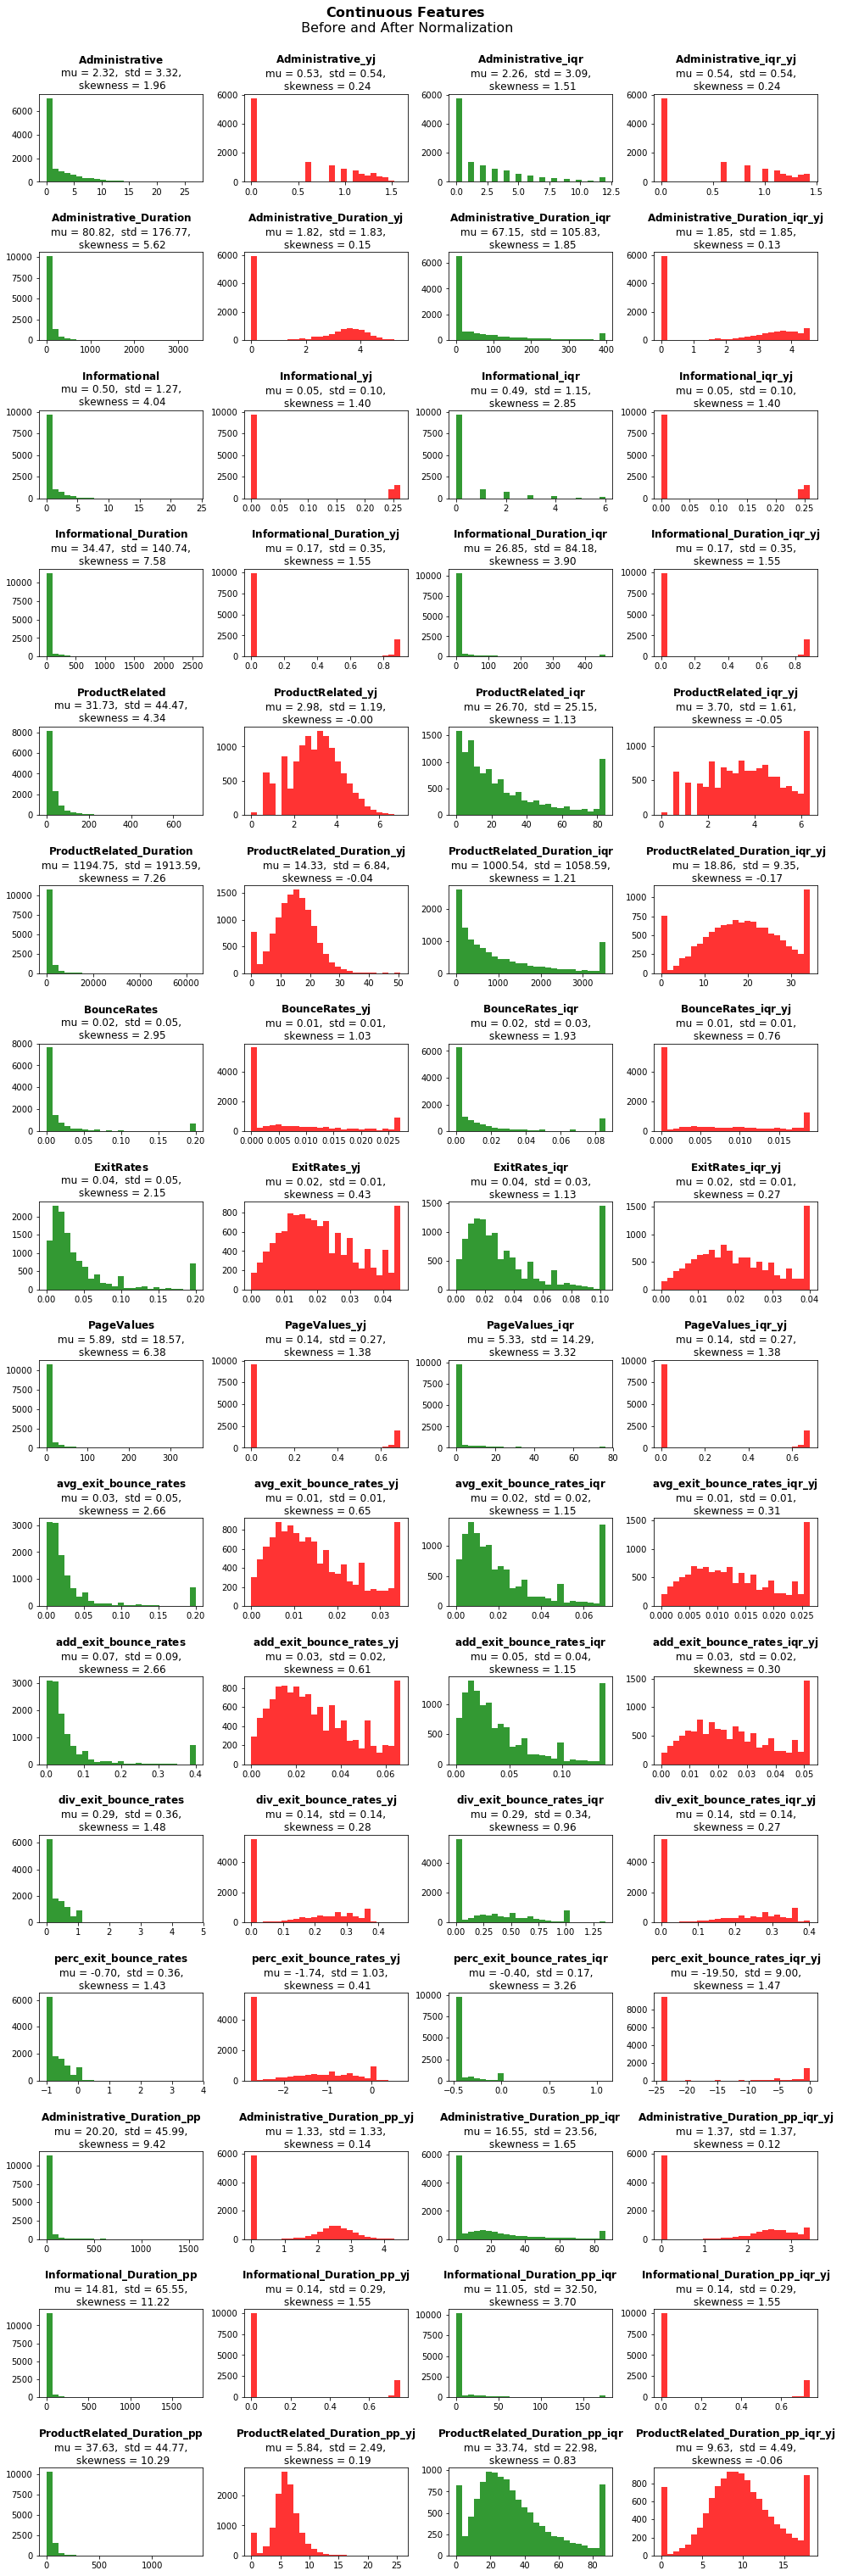

In [19]:
# define (pair-wise) list to plot histograms of, in the following sequence: 
# 1st the feature before normalization, 
# 2nd the feature after outlier removal (IQR)
# 3rd the feature after normalization etc.
lst_continuous_cols = ['Administrative', 'Administrative_yj', 'Administrative_iqr', 'Administrative_iqr_yj', 
                       'Administrative_Duration', 'Administrative_Duration_yj', 'Administrative_Duration_iqr', 'Administrative_Duration_iqr_yj', 
                       'Informational', 'Informational_yj', 'Informational_iqr', 'Informational_iqr_yj',
                       'Informational_Duration', 'Informational_Duration_yj', 'Informational_Duration_iqr', 'Informational_Duration_iqr_yj',
                       'ProductRelated', 'ProductRelated_yj', 'ProductRelated_iqr', 'ProductRelated_iqr_yj',
                       'ProductRelated_Duration', 'ProductRelated_Duration_yj', 'ProductRelated_Duration_iqr', 'ProductRelated_Duration_iqr_yj',
                       'BounceRates', 'BounceRates_yj', 'BounceRates_iqr', 'BounceRates_iqr_yj',
                       'ExitRates', 'ExitRates_yj', 'ExitRates_iqr', 'ExitRates_iqr_yj', 
                       'PageValues', 'PageValues_yj', 'PageValues_iqr', 'PageValues_iqr_yj', 
                       'avg_exit_bounce_rates', 'avg_exit_bounce_rates_yj', 'avg_exit_bounce_rates_iqr', 'avg_exit_bounce_rates_iqr_yj',
                       'add_exit_bounce_rates', 'add_exit_bounce_rates_yj', 'add_exit_bounce_rates_iqr', 'add_exit_bounce_rates_iqr_yj',
                       'div_exit_bounce_rates', 'div_exit_bounce_rates_yj', 'div_exit_bounce_rates_iqr', 'div_exit_bounce_rates_iqr_yj',
                       'perc_exit_bounce_rates', 'perc_exit_bounce_rates_yj', 'perc_exit_bounce_rates_iqr', 'perc_exit_bounce_rates_iqr_yj',
                       'Administrative_Duration_pp', 'Administrative_Duration_pp_yj', 'Administrative_Duration_pp_iqr', 'Administrative_Duration_pp_iqr_yj',
                       'Informational_Duration_pp', 'Informational_Duration_pp_yj', 'Informational_Duration_pp_iqr', 'Informational_Duration_pp_iqr_yj',
                       'ProductRelated_Duration_pp', 'ProductRelated_Duration_pp_yj', 'ProductRelated_Duration_pp_iqr', 'ProductRelated_Duration_pp_iqr_yj']

hist_subplots(df, lst_continuous_cols)

<b> 2.7 Skewness before and after the normalization

## Skewness ##
>* If skewness is less than −1 or greater than +1, the distribution is highly skewed.
* If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
* If skewness is between −½ and +½, the distribution is approximately symmetric.
* A symmetrical distribution has a skewness of zero.
* An asymmetrical distribution with a long tail to the right (higher values) has a positive skew.
* An asymmetrical distribution with a long tail to the left (lower values) has a negative skew.

<b> 2.7.1 Create a function to get the skewness of a list of features, whereby the sequence is as follows: </b>
* First item in the list is the original feature
* Second item in the list is the normalized feature etc.

In [20]:
def skewness_cols(df, col_list):
    # create empty lists to append to in the for-loop
    lst_skewness_original = []
    lst_skewness_normalized = []
    lst_original_cols = []
    lst_normalized_cols = []
    
    lst_original_cols_skewness_description = []
    lst_normalized_cols_skewness_description = []
    
    # iterate through the columns in the list and determine skewness for each and create a new pandas dataframe
    for i, col in enumerate(df[col_list]):
        skewness = skew(df[col])
        if i % 2 == 0:
            lst_skewness_original.append(skewness)
            lst_original_cols.append(col)
            if -0.5 < skewness < 0.5:
                lst_original_cols_skewness_description.append('~symmetric')
            elif  -0.5 < skewness < -1.0 or 0.5 < skewness < 1.0:
                lst_original_cols_skewness_description.append('moderate')
            else:
                lst_original_cols_skewness_description.append('high')
        else:
            lst_skewness_normalized.append(skewness)
            lst_normalized_cols.append(col)
            if -0.5 < skewness < 0.5:
                lst_normalized_cols_skewness_description.append('~symmetric')
            elif  -0.5 < skewness < -1.0 or 0.5 < skewness < 1.0:
                lst_normalized_cols_skewness_description.append('moderate')
            else:
                lst_normalized_cols_skewness_description.append('high')
            
    # convert 4 lists into a pandas dataframe
    df_skewness = pd.DataFrame([lst_original_cols, lst_skewness_original, lst_original_cols_skewness_description, 
                                lst_normalized_cols, lst_skewness_normalized, lst_normalized_cols_skewness_description]).T
    # add column headers
    df_skewness.columns = ['Original Feature', 'Skewness', 'Distribution Skewness', 'Normalized Feature', 'Skewness', 'Distribution Skewness']
    return(df_skewness)

<b> 2.7.2 Apply function to test the skewness of continuous features

In [21]:
# apply function
lst_continuous_cols = ['Administrative', 'Administrative_iqr_yj', 
                       'Administrative_Duration', 'Administrative_Duration_iqr_yj', 
                       'Informational', 'Informational_iqr_yj',
                       'Informational_Duration', 'Informational_Duration_iqr_yj',
                       'ProductRelated', 'ProductRelated_iqr_yj',
                       'ProductRelated_Duration', 'ProductRelated_Duration_iqr_yj',
                       'BounceRates','BounceRates_iqr_yj',
                       'ExitRates', 'ExitRates_iqr_yj', 
                       'PageValues', 'PageValues_iqr_yj', 
                       'avg_exit_bounce_rates', 'avg_exit_bounce_rates_iqr_yj',
                       'add_exit_bounce_rates', 'add_exit_bounce_rates_iqr_yj',
                       'div_exit_bounce_rates', 'div_exit_bounce_rates_iqr_yj',
                       'perc_exit_bounce_rates', 'perc_exit_bounce_rates_iqr_yj',
                       'Administrative_Duration_pp', 'Administrative_Duration_pp_iqr_yj',
                       'Informational_Duration_pp', 'Informational_Duration_pp_iqr_yj',
                       'ProductRelated_Duration_pp', 'ProductRelated_Duration_pp_iqr_yj']

# show dataframe with skewness before and after normalization for continuous features
skewness_cols(df, lst_continuous_cols)

,Original Feature,Skewness,Distribution Skewness,Normalized Feature,Skewness,Distribution Skewness
0,Administrative,1.96012,high,Administrative_iqr_yj,0.239285,~symmetric
1,Administrative_Duration,5.61504,high,Administrative_Duration_iqr_yj,0.131537,~symmetric
2,Informational,4.03597,high,Informational_iqr_yj,1.40368,high
3,Informational_Duration,7.57826,high,Informational_Duration_iqr_yj,1.54637,high
4,ProductRelated,4.34099,high,ProductRelated_iqr_yj,-0.0468368,~symmetric
5,ProductRelated_Duration,7.26234,high,ProductRelated_Duration_iqr_yj,-0.165409,~symmetric
6,BounceRates,2.9475,high,BounceRates_iqr_yj,0.758085,moderate
7,ExitRates,2.14853,high,ExitRates_iqr_yj,0.267339,~symmetric
8,PageValues,6.38219,high,PageValues_iqr_yj,1.37668,high
9,avg_exit_bounce_rates,2.65832,high,avg_exit_bounce_rates_iqr_yj,0.313347,~symmetric


<a id = "3"> <h2> 3. Standardization Z-score </h2> </a>
___

<b> _Convert the features values to the same numeric level._ </b>
<br> This is also called: Data Scaling.

* For this pipeline the z-score standardization is chosen, which is calculated as shown on [this page](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/).
<br> _Requirement:_ First normalize the data before you standardize with z-score

<b> 3.1 Create a function for the z-score 

In [22]:
def replace_columns_zscore(df, column_list): 
    for my_col in column_list:      
        # combine old column name with a suffix for the new name of the column
        suffix = '_zscore'
        my_new_col = ''.join([my_col, suffix])
        # create a new column with the name: (column name + suffix)
        df[my_new_col] = df[my_col]
        # apply zscore to new column
        df[my_new_col] = stats.zscore(df[my_new_col])
        
        # 2nd method to apply zscore without the scipy.stats.zscore package
        #df[my_new_col] = (df[my_new_col] - df[my_new_col].mean())/df[my_new_col].std(ddof=0)

<b> 3.2 Apply the function z-score to each normalized continuous feature

In [23]:
lst_continuous_cols = ['Administrative_iqr_yj', 
                       'Administrative_Duration_iqr_yj', 
                       'Informational_iqr_yj',
                       'Informational_Duration_iqr_yj',
                       'ProductRelated_iqr_yj',
                       'ProductRelated_Duration_iqr_yj',
                       'BounceRates_iqr_yj',
                       'ExitRates_iqr_yj', 
                       'PageValues_iqr_yj', 
                       'avg_exit_bounce_rates_iqr_yj',
                       'add_exit_bounce_rates_iqr_yj',
                       'div_exit_bounce_rates_iqr_yj',
                       'perc_exit_bounce_rates_iqr_yj',
                       'Administrative_Duration_pp_iqr_yj',
                       'Informational_Duration_pp_iqr_yj',
                       'ProductRelated_Duration_pp_iqr_yj']

replace_columns_zscore(df=df, column_list=lst_continuous_cols) 

<b> 3.3 Test if columns were created

In [24]:
# test if all additional columns were created with a suffix _zscore
zscore_cols = [col for col in df.columns if '_zscore' in col]
# show columns where names contains the string 'iqr'
print('number of continuous features:', len(zscore_cols))
zscore_cols

number of continuous features: 16


['Administrative_iqr_yj_zscore',
 'Administrative_Duration_iqr_yj_zscore',
 'Informational_iqr_yj_zscore',
 'Informational_Duration_iqr_yj_zscore',
 'ProductRelated_iqr_yj_zscore',
 'ProductRelated_Duration_iqr_yj_zscore',
 'BounceRates_iqr_yj_zscore',
 'ExitRates_iqr_yj_zscore',
 'PageValues_iqr_yj_zscore',
 'avg_exit_bounce_rates_iqr_yj_zscore',
 'add_exit_bounce_rates_iqr_yj_zscore',
 'div_exit_bounce_rates_iqr_yj_zscore',
 'perc_exit_bounce_rates_iqr_yj_zscore',
 'Administrative_Duration_pp_iqr_yj_zscore',
 'Informational_Duration_pp_iqr_yj_zscore',
 'ProductRelated_Duration_pp_iqr_yj_zscore']

<b> 3.4 Test if the zscore changed the mean and standard deviation to zero for the features

In [25]:
df[zscore_cols].describe().loc[['mean', 'std']].round(2)

,Administrative_iqr_yj_zscore,Administrative_Duration_iqr_yj_zscore,Informational_iqr_yj_zscore,Informational_Duration_iqr_yj_zscore,ProductRelated_iqr_yj_zscore,ProductRelated_Duration_iqr_yj_zscore,BounceRates_iqr_yj_zscore,ExitRates_iqr_yj_zscore,PageValues_iqr_yj_zscore,avg_exit_bounce_rates_iqr_yj_zscore,add_exit_bounce_rates_iqr_yj_zscore,div_exit_bounce_rates_iqr_yj_zscore,perc_exit_bounce_rates_iqr_yj_zscore,Administrative_Duration_pp_iqr_yj_zscore,Informational_Duration_pp_iqr_yj_zscore,ProductRelated_Duration_pp_iqr_yj_zscore
mean,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<a id = "4"> <h2> 4. Correlation Analysis </h2> </a>
___

<b> 4.1 Create a list of the continuous features and a list of the categorical features </b>
<br> We will use these lists of features to do the pair-wise correlation analysis on.

In [26]:
####################################################################################
# get the list of the continuous features, whereby:
# outliers removed with IQR (used suffix _iqr)
# normalized using yeojohnson (used suffix _yj)
# standardized using Z-score (used suffix _zscore)
####################################################################################
lst_continuous_features = [col for col in df.columns if '_iqr_yj_zscore' in col]
## test if list is correct
#lst_continuous_features

####################################################################################
# get the list of the categorical features
####################################################################################
## only get the boolean features, where the values are unique with 0 and 1 integers
# create an empty list to append the categorical features column names to
lst_categorical_features = []

# iterate through the pandas dataframe and check if the unique values are of length 2
for column in df:
    # get a list of unique values for each column in the dataframe
    lst_values = df[column].unique()
    # if the length of the list is equal to 2, it can be a boolean with values [0 1] or [1 0]
    if len(lst_values) == 2:
        lst_categorical_features.append(column)
        
# drop target variable from the categorical list
lst_categorical_features.remove('Revenue')
        
# check if the list contains only categorical features
#print(lst_categorical_features)

####################################################################################
# Combine the lists to get a combined list of all the features in the dataset 
# (used in Feature Selection)
####################################################################################
lst_all_features = lst_continuous_features+lst_categorical_features
# show list with all features (continuous + categorical)
#lst_all_features

### 4.2 Pairwise Pearson's Correlation between Continuous Features
___

<b> 4.2.1 Define correlation matrix (absolute correlation values)

In [27]:
corr_matrix = df[lst_continuous_features].corr(method='pearson').abs()
# show correlation matrix
#corr_matrix

<b> 4.2.2 Creat a function to get a list of the Pearson's pairwise correlations higher than a treshhold value (set to 0.5)

In [28]:
# create a function to drop the redundant pairs in the correlation matrix (all correlations are mirrored diagionaly)
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method='pearson').abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print('--------------------------------------------------------------------------------------------')
print('               Top Absolute Pearson`s Correlations between Continuous Features (>0.5)       ')
print('--------------------------------------------------------------------------------------------')

# only show correlations higher or equal to 0.5
get_top_abs_correlations(corr_matrix, n=10000)[get_top_abs_correlations(corr_matrix, n=10000) >= 0.5]

# Our threshold is set to 0.5 for dropping either one of the highly correlated variables

--------------------------------------------------------------------------------------------
               Top Absolute Pearson`s Correlations between Continuous Features (>0.5)       
--------------------------------------------------------------------------------------------


avg_exit_bounce_rates_iqr_yj_zscore    add_exit_bounce_rates_iqr_yj_zscore         0.999999
Informational_Duration_iqr_yj_zscore   Informational_Duration_pp_iqr_yj_zscore     0.999999
Informational_iqr_yj_zscore            Informational_Duration_iqr_yj_zscore        0.997419
                                       Informational_Duration_pp_iqr_yj_zscore     0.997378
Administrative_Duration_iqr_yj_zscore  Administrative_Duration_pp_iqr_yj_zscore    0.997324
Administrative_iqr_yj_zscore           Administrative_Duration_iqr_yj_zscore       0.994240
                                       Administrative_Duration_pp_iqr_yj_zscore    0.984005
BounceRates_iqr_yj_zscore              div_exit_bounce_rates_iqr_yj_zscore         0.972661
ExitRates_iqr_yj_zscore                add_exit_bounce_rates_iqr_yj_zscore         0.972173
                                       avg_exit_bounce_rates_iqr_yj_zscore         0.972139
ProductRelated_iqr_yj_zscore           ProductRelated_Duration_iqr_yj_zscore    

<b> 4.2.3 Visualize the Pairwise correlation between continuous features

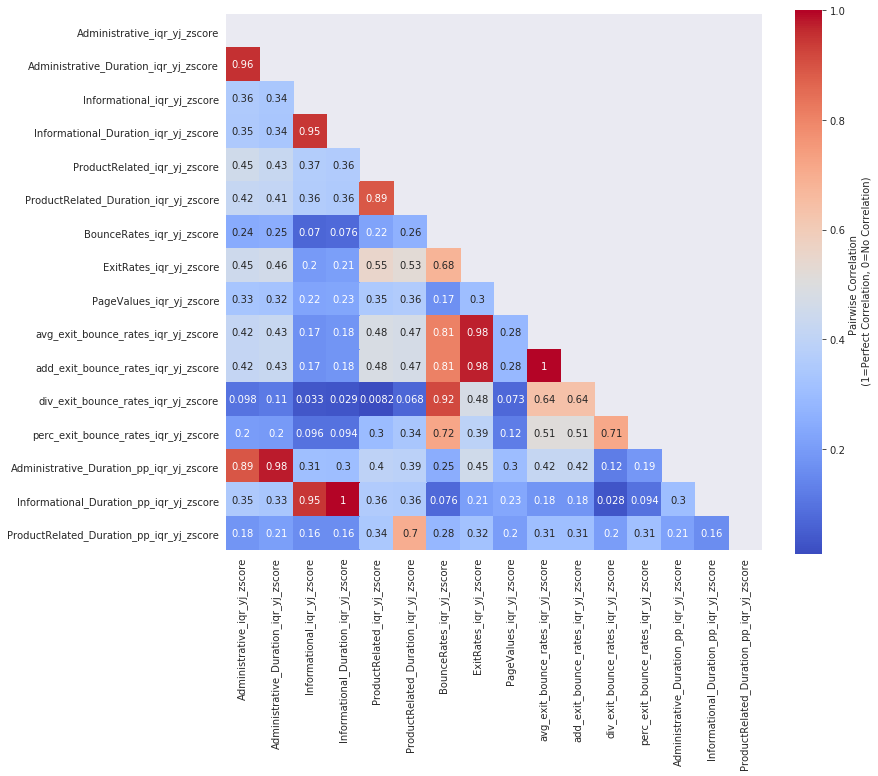

In [29]:
# Create a heatmap from our Pearson's correlation matrix
# source: https://seaborn.pydata.org/generated/seaborn.heatmap.html
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(12, 10))
    # plot a seaborn heatmap with labels inside (annot=True), a title for the bar (cbar_kws) and colorstyle (cmap)
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=1, square=True, annot=True, cbar_kws={'label': 'Pairwise Correlation \n (1=Perfect Correlation, 0=No Correlation)'}, cmap="coolwarm")

### 4.3 Pairwise Correlation between categorical features
___

In [30]:
# Define correlation matrix (absolute correlation values)
corr_matrix = df[lst_categorical_features].corr(method='pearson').abs()
# show correlation matrix
#corr_matrix

get_top_abs_correlations(corr_matrix, n=10000)[get_top_abs_correlations(corr_matrix, n=10000) >= 0.5]

OperatingSystems_5       Browser_11                       1.000000
VisitorType_New_Visitor  VisitorType_Returning_Visitor    0.982194
OperatingSystems_1       Browser_1                        0.972940
OperatingSystems_8       Browser_13                       0.969027
Browser_13               VisitorType_Other                0.954997
OperatingSystems_8       VisitorType_Other                0.939740
Browser_1                Browser_2                        0.884188
OperatingSystems_1       Browser_2                        0.853555
Browser_13               TrafficType_20                   0.837791
OperatingSystems_1       OperatingSystems_2               0.816843
OperatingSystems_2       OperatingSystems_3               0.802766
                         Browser_1                        0.798482
OperatingSystems_8       TrafficType_20                   0.778897
TrafficType_20           VisitorType_Other                0.762523
Month_May                SpecialDay_0.0                   0.74

<a id = "5"> <h2> 5. Binning </h2> </a>
___

_Note:_ The categorical features are already one-hot encoded, however we could also bin them, for example bin the months by quarter

In [31]:
# show categorical features
#lst_categorical_features

In [32]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,SpecialDay_0.0,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,avg_exit_bounce_rates,add_exit_bounce_rates,div_exit_bounce_rates,perc_exit_bounce_rates,Administrative_Duration_pp,Informational_Duration_pp,ProductRelated_Duration_pp,Administrative_iqr,Administrative_Duration_iqr,Informational_iqr,Informational_Duration_iqr,ProductRelated_iqr,ProductRelated_Duration_iqr,BounceRates_iqr,ExitRates_iqr,PageValues_iqr,avg_exit_bounce_rates_iqr,add_exit_bounce_rates_iqr,div_exit_bounce_rates_iqr,perc_exit_bounce_rates_iqr,Administrative_Duration_pp_iqr,Informational_Duration_pp_iqr,ProductRelated_Duration_pp_iqr,Administrative_yj,Administrative_iqr_yj,Administrative_Duration_yj,Administrative_Duration_iqr_yj,Informational_yj,Informational_iqr_yj,Informational_Duration_yj,Informational_Duration_iqr_yj,ProductRelated_yj,ProductRelated_iqr_yj,ProductRelated_Duration_yj,ProductRelated_Duration_iqr_yj,BounceRates_yj,BounceRates_iqr_yj,ExitRates_yj,ExitRates_iqr_yj,PageValues_yj,PageValues_iqr_yj,avg_exit_bounce_rates_yj,avg_exit_bounce_rates_iqr_yj,add_exit_bounce_rates_yj,add_exit_bounce_rates_iqr_yj,div_exit_bounce_rates_yj,div_exit_bounce_rates_iqr_yj,perc_exit_bounce_rates_yj,perc_exit_bounce_rates_iqr_yj,Administrative_Duration_pp_yj,Administrative_Duration_pp_iqr_yj,Informational_Duration_pp_yj,Informational_Duration_pp_iqr_yj,ProductRelated_Duration_pp_yj,ProductRelated_Duration_pp_iqr_yj,Administrative_iqr_yj_zscore,Administrative_Duration_iqr_yj_zscore,Informational_iqr_yj_zscore,Informational_Duration_iqr_yj_zscore,ProductRelated_iqr_yj_zscore,ProductRelated_Duration_iqr_yj_zscore,BounceRates_iqr_yj_zscore,ExitRates_iqr_yj_zscore,PageValues_iqr_yj_zscore,avg_exit_bounce_rates_iqr_yj_zscore,add_exit_bounce_rates_iqr_yj_zscore,div_exit_bounce_rates_iqr_yj_zscore,perc_exit_bounce_rates_iqr_yj_zscore,Administrative_Duration_pp_iqr_yj_zscore,Informational_Duration_pp_iqr_yj_zscore,ProductRelated_Duration_pp_iqr_yj_zscore
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.200,0.40,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.085561,0.103571,0.0,0.070255,0.140509,1.000000,0.000000,0.0,0.0,0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.697694,0.731372,0.000000,0.000000,0.027175,0.018956,0.045231,0.040065,-0.0,-0.0,0.034729,0.026445,0.066653,0.052060,0.367377,0.369173,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,0.000000,0.000000,-0.990557,-0.9983,-0.520508,-0.491723,-1.840859,-2.018035,1.902967,1.710490,-0.529467,1.703795,1.699950,1.584430,2.167818,-1.003395,-0.491728,-2.144632
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.050,0.10,0.000000,-1.000000,0.0,0.0,32.000000,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.050000,0.100000,0.000000,-0.

In [33]:
# Bin the months into quarters (Q1, Q2, Q3, Q4) respectively
df['Q1'] = df['Month_Feb']+df['Month_Mar'] # Note Month_Jan is missing from dataset
df['Q2'] = df['Month_May']+df['Month_June'] # Note Month_Apr is missing from dataset
df['Q3'] = df['Month_Jul']+df['Month_Aug']+df['Month_Sep']
df['Q4'] = df['Month_Oct']+df['Month_Nov']+df['Month_Dec']

# Visually inspect if binning worked correctly (note that Q1 only has two months in the bin (No January in dataset) and Q2 only has 2 months in the bin (no April in dataset))
df_test_months = df[['Month_Feb', 'Month_Mar', 'Month_May', 'Month_June', 'Month_Jul', 'Month_Aug', 'Month_Sep', 'Month_Oct', 'Month_Nov', 'Month_Dec', 'Q1', 'Q2', 'Q3', 'Q4']]
df_test_months = df_test_months.drop_duplicates()
# sort the matrix for easier readability of the months and their respective quarterly bin
df_test_months.sort_values(by=['Month_Feb', 'Month_Mar', 'Month_May', 'Month_June', 'Month_Jul', 'Month_Aug', 'Month_Sep', 'Month_Oct', 'Month_Nov', 'Month_Dec'], axis=0, ascending=False)

,Month_Feb,Month_Mar,Month_May,Month_June,Month_Jul,Month_Aug,Month_Sep,Month_Oct,Month_Nov,Month_Dec,Q1,Q2,Q3,Q4
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
184,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2091,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5456,0,0,0,1,0,0,0,0,0,0,0,1,0,0
5460,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5462,0,0,0,0,0,1,0,0,0,0,0,0,1,0
5468,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5455,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5463,0,0,0,0,0,0,0,0,1,0,0,0,0,1
7982,0,0,0,0,0,0,0,0,0,1,0,0,0,1


<a id = "6"> <h2> 6. Feature Selection </h2> </a>
___

Three methods are selected for feature selection:
- Recursive Feature Elimination (RFE)
- SelectKBest
- Ridge Regression

Out of the three methods a combination is chosen of the top selected features from each method.

## RFE

<b> 6.1 Define Features (X) and Target (Y)

In [34]:
####################################################################################
# get the list of the continuous features, whereby:
# outliers removed with IQR (used suffix _iqr)
# normalized using yeojohnson (used suffix _yj)
# standardized using Z-score (used suffix _zscore)
####################################################################################
lst_continuous_features = [col for col in df.columns if '_iqr_yj_zscore' in col]
## test if list is correct
#lst_continuous_features

####################################################################################
# get the list of the categorical features
####################################################################################
## only get the boolean features, where the values are unique with 0 and 1 integers
# create an empty list to append the categorical features column names to
lst_categorical_features = []

# iterate through the pandas dataframe and check if the unique values are of length 2
for column in df:
    # get a list of unique values for each column in the dataframe
    lst_values = df[column].unique()
    # if the length of the list is equal to 2, it can be a boolean with values [0 1] or [1 0]
    if len(lst_values) == 2:
        lst_categorical_features.append(column)
        
# drop target variable from the categorical list
lst_categorical_features.remove('Revenue')
        
# check if the list contains only categorical features
#print(lst_categorical_features)

####################################################################################
# Combine the lists to get a combined list of all the features in the dataset 
# (used in Feature Selection)
####################################################################################
lst_all_features = lst_continuous_features+lst_categorical_features
# show list with all features (continuous + categorical)
#lst_all_features

In [35]:
# Define Features
X = df[lst_all_features].to_numpy()

# Define Target
Y = df['Revenue']

<b> 6.2 Feature Selection method: Recursive Feature Elimination (RFE) </b>

The <b> Recursive Feature Elimination </b> (RFE) method is a feature selection approach.
<br> It works by recursively removing attributes and building a model on those attributes that remain. 
<br> It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.
<br> _source:_ https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

For additional information about RFE, click [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE).

### Gridsearch -> Finding the optimal hyper-parameters for RFE

In [36]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# load libraries
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# source: https://www.dezyre.com/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python

# ignore warnings
warnings.filterwarnings("ignore")

# Create a logistic regression object with an L2 penalty
logistic = linear_model.LogisticRegression()
   
pipe = Pipeline(steps=[('logistic', logistic)])    

# Create a list of options for the regularization penalty
penalty = ['l1', 'l2']
# Create a list of values of the regularization parameter
C = np.logspace(-4, 4, 50)

parameters = dict(logistic__penalty=penalty, logistic__C=C)

# Create a grid search object
clf = GridSearchCV(pipe, parameters)
#clf_cv = GridSearchCV(LogisticRegression, parameters)

# Fit the grid search
clf.fit(X, Y)

# View The Best Parameters
print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic__C'])

optimal_penalty = clf.best_estimator_.get_params()['logistic__penalty']
optimal_C = clf.best_estimator_.get_params()['logistic__C']

Best Penalty: l2
Best C: 0.040949150623804234


apply RFE model

In [37]:
# turn of the following warnings: 
# ConvergenceWarning: lbfgs failed to converge
# Increase the number of iterations (max_iter) or scale the data as shown in:
warnings.filterwarnings("ignore")

# Feature extraction
# for parameters in LogisticRegression function, see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model = LogisticRegression(penalty=optimal_penalty, max_iter=200, random_state=2019, C=optimal_C)
rfe = RFE(model, 10)
fit = rfe.fit(X, Y)

# reset the warnings for future code
warnings.resetwarnings()

convert results to a dataframe with the features and respective ranking

In [38]:
# --------------------------------------------------------
# Get the column names and the ranking in a new dataframe
# --------------------------------------------------------
# convert numpy array to list
list_ranking = fit.ranking_.tolist()

# convert 2 lists into a dictionary
dict_ranking = {'Feature': lst_all_features, 'RFE Rank': list_ranking}

# convert the dictionary into a pandas dataframe
df_test_ranking = pd.DataFrame(dict_ranking)

# set Feature as the index of the pandas dataframe
#df_test_ranking.set_index('Feature', inplace=True)

# order by rank
df_rfe_rank = df_test_ranking.sort_values(by=['RFE Rank'], ascending=True).head(50)
# reset the index of the pandas dataframe and drop the old index
df_rfe_rank.reset_index(inplace=True, drop=True)

<b> RFE feature selection for target "Revenue"

In [39]:
# show dataframe with the RFE ranking of the features (top10 == 1)
df_rfe_rank

,Feature,RFE Rank
0,Q4,1
1,Month_Dec,1
2,Q3,1
3,TrafficType_8,1
4,Month_Nov,1
5,VisitorType_New_Visitor,1
6,PageValues_iqr_yj_zscore,1
7,TrafficType_13,1
8,VisitorType_Returning_Visitor,1
9,ExitRates_iqr_yj_zscore,1


<b> 6.3 Feature Selection method: SelectKBest
___

## SelectKBest:
- Removes all but the highest scoring K features
- SelectKBest only works with positive features!
<br> _source:_ https://scikit-learn.org/stable/modules/feature_selection.html

<b> 6.3.1  Define positive features to apply SelectKBest to

In [40]:
# ------------------------------------------------------------------------------------------------
# find all features that have non-negative values and make a list of it
# in order to use Kbest Feature Selection
# ------------------------------------------------------------------------------------------------
# create a condition whereby you test which columns have a minimum bigger or equal to zero
condition_nonnegative_values = df[lst_all_features].min() >= 0

# only show the features where condition equals True in a 2D array (columnname, True/False)
features_nonnegative_values = condition_nonnegative_values[condition_nonnegative_values == True]

# create a list with only positive features to use for Kbest method
list_kbest_features = features_nonnegative_values.index.tolist()

<b> 6.3.2 Define Features (X) and the Target (Y)

In [41]:
# ---------------------------------
# Define dependent variables
# ---------------------------------
# Define dependent variables and save it as a numpy array
X = df[list_kbest_features].to_numpy()

# ---------------------------------
# Define independent variable: "Revenue"
# ---------------------------------
Y = df['Revenue']

<b> 6.3.3 Apply SelectKBest

In [42]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# Summarize scores
#np.set_printoptions(precision=3)
#print(fit.scores_)

<b> 6.3.4 Show Results Kbest

In [43]:
# create a dataframe with scores ranked from large to small scores for features (transpose dataframe)
df_kbest_features = pd.DataFrame([list_kbest_features, fit.scores_.tolist()]).transpose()

# rename columns of dataframe
df_kbest_features.columns = ['Feature', 'Score']

## order by Score descending and reset index after sorting
df_kbest_rank = df_kbest_features.sort_values(by=['Score'], ascending=False).reset_index(drop=True)

# show dataframe (top 20 features of Kbest)
df_kbest_rank.head(60)

,Feature,Score
0,Month_Nov,223.548
1,VisitorType_New_Visitor,115.339
2,TrafficType_2,113.937
3,Q4,109.53
4,TrafficType_3,70.4775
5,Q2,61.306
6,Q1,60.4404
7,Month_May,54.9971
8,TrafficType_13,52.5192
9,OperatingSystems_3,48.5462


<b> 6.4 Feature Selection method: Ridge Regression
___

### Ridge Regression
For more information about Ridge feature selection,  click on the [link](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/#three)

In [44]:
# Define Features
# Note: if you wish to see how the list of all features was derived, refer to top codeblock at section: 'Correlation Analysis' 
X = df[lst_all_features].to_numpy()

# Define Target
Y = df['Revenue']

In [45]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X,Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [46]:
# create a dataframe with scores ranked from large to small scores for features (transpose dataframe)
df_ridge_features = pd.DataFrame([lst_all_features, list(ridge.coef_)]).transpose()

# rename columns of dataframe
df_ridge_features.columns = ['Feature', 'Coefficient']

## order by Score descending and reset index after sorting
df_ridge_rank = df_ridge_features.sort_values(by=['Coefficient'], ascending=False).reset_index(drop=True)

# show dataframe (top 15 features)
df_ridge_rank.head(15)

,Feature,Coefficient
0,PageValues_iqr_yj_zscore,0.222361
1,TrafficType_16,0.208791
2,Browser_12,0.172895
3,OperatingSystems_7,0.121622
4,Administrative_Duration_pp_iqr_yj_zscore,0.0945238
5,Browser_13,0.0763061
6,Month_Nov,0.0650887
7,VisitorType_New_Visitor,0.0471734
8,TrafficType_8,0.0438906
9,avg_exit_bounce_rates_iqr_yj_zscore,0.0379914


<b> 6.5 Get the top 'n' rankings of features in a list (based on RFE and KBest Feature Selection)
- whereby n is an integer, representing of the number of features you would like to keep 
____

Take in a sequence each top 'n' features from the two lists RFE and KBest

In [47]:
test_list1 = list(df_rfe_rank['Feature'])
test_list2 = list(df_kbest_rank['Feature'])

# consecutive element pairing of two lists
# source: https://www.geeksforgeeks.org/python-consecutive-elements-pairing-in-list/
res = list(map(list, zip(test_list1, test_list2[0:])))
l = res

# combine the list of lists into a single list
# source: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
flat_list = [item for sublist in l for item in sublist]

# remove duplicates from the list
# source: https://www.w3schools.com/python/python_howto_remove_duplicates.asp
mylist = list(dict.fromkeys(flat_list))

# show mylist
#mylist

In [48]:
# remove one of the highly correlated pair-wise features from list
# source: https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python

# Create features and target
X = df[mylist]
y = df['Revenue']

# Convert feature matrix into DataFrame
df_corr = df[mylist]

# Create correlation matrix
corr_matrix = df_corr.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# Drop Marked Features
df_features = df_corr.drop(to_drop, axis=1)

In [49]:
# show features that are dropped while selecting the top 20 features:
#to_drop

In [50]:
# only keep top 'n' features of the dataframe (because they are ordered according to their top ranking (left-to-right) we can discard the right part with syntax iloc)

# select how many top features based on RFE and KBest you want to keep
n = 20
print('maximum number of features to select as top features:', len(df_features.columns))
print('chosen number of features to select as top features:', n)

# keep only the first n features
df_top_features = df_features.iloc[:, 0:n]

print('---------------------------')
print('list of features selected:')
print('---------------------------')
list(df_top_features.columns)

maximum number of features to select as top features: 47
chosen number of features to select as top features: 20
---------------------------
list of features selected:
---------------------------


['Q4',
 'Month_Dec',
 'VisitorType_New_Visitor',
 'Q3',
 'TrafficType_2',
 'TrafficType_8',
 'TrafficType_3',
 'PageValues_iqr_yj_zscore',
 'Q1',
 'TrafficType_13',
 'ExitRates_iqr_yj_zscore',
 'OperatingSystems_3',
 'Administrative_Duration_iqr_yj_zscore',
 'TrafficType_1',
 'SpecialDay_0.8',
 'Month_Feb',
 'Browser_6',
 'SpecialDay_0.4',
 'TrafficType_20',
 'Informational_Duration_pp_iqr_yj_zscore']

<b> 6.5.2 Compare which top 'n' features, selected from RFE and KBest models, are not included in the top 'm' features from the Ridge model

_Note:_ we got the top 20 features of a combined list of both RFE and KBest, we add the top 10 (m=10) list of Ridge that is not already incldued in the list of top features

In [51]:
m=10
# get the m number of top features from the previous Ridge Feature Selection method
df_ridge_topfeatures = df_ridge_rank.iloc[0:m, 0]
# convert it into a list of column names
#list(df_ridge_topfeatures)

In [52]:
# function to get the unique elements from the second list that are not in the first list
# source: https://stackoverflow.com/questions/41125909/python-find-elements-in-one-list-that-are-not-in-the-other
def setdiff_sorted(array1,array2,assume_unique=False):
    ans = np.setdiff1d(array1,array2,assume_unique).tolist()
    if assume_unique:
        return sorted(ans)
    return ans

# define the lists
list_1 = list(df_top_features.columns)
list_2 = list(df_ridge_topfeatures)

# apply the function to the list with top 'n' features selected and the list with top 'm' features of ridge
features_excluded_from_main_list = setdiff_sorted(list_2,list_1)
# show the list of column names
features_excluded_from_main_list

['Administrative_Duration_pp_iqr_yj_zscore',
 'Browser_12',
 'Browser_13',
 'Month_Nov',
 'OperatingSystems_7',
 'TrafficType_16',
 'avg_exit_bounce_rates_iqr_yj_zscore']

In [53]:
# add the Ridge suggested features to the dataframe copy from the Ridge model
df_ridge_features = df[features_excluded_from_main_list] 
# merge two dataframes of (RFE+Kbest) top features and Ridge top features (non-duplicates)
df_top_features = pd.concat([df_top_features, df_ridge_features], axis=1)
# show new dataframe
# df_top_features

In [54]:
# remove highly correlated features in top features list
df_corr = df_top_features

# Create correlation matrix
corr_matrix = df_corr.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# Drop Marked Features
df_top_features = df_corr.drop(to_drop, axis=1)

<b> 6.5.3 Visually Inspect if the top features (list combined of RFE, KBest and Ridge Feature selection) are not highyl correlated (<0.5)

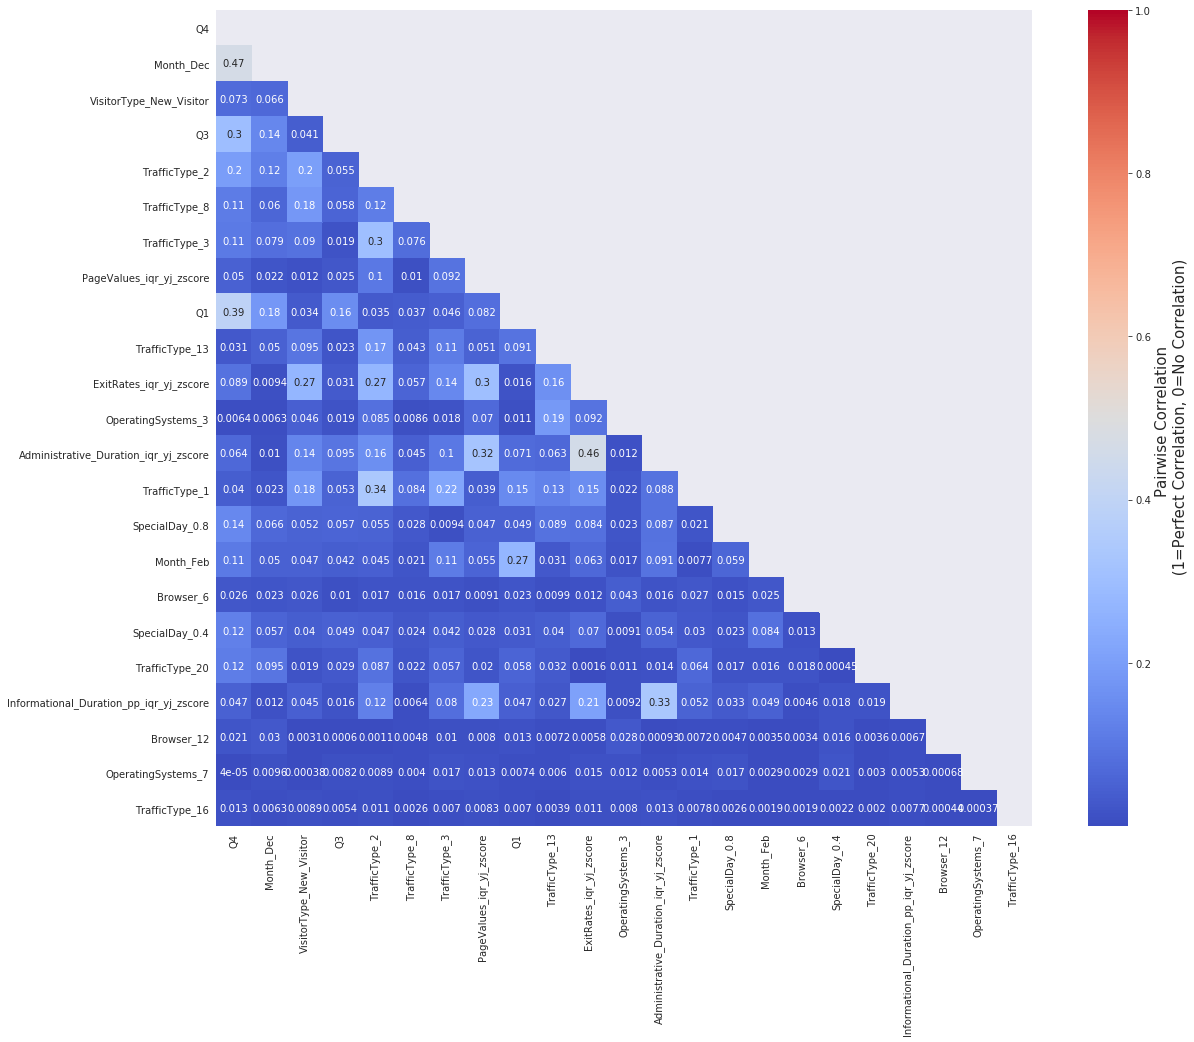

In [55]:
# Create a heatmap from our Pearson's correlation matrix
# source: https://seaborn.pydata.org/generated/seaborn.heatmap.html
corr_matrix = df_top_features.corr().abs()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(20, 15))
    # plot a seaborn heatmap with labels inside (annot=True), a title for the bar (cbar_kws) and colorstyle (cmap)

    ax = sns.heatmap(corr_matrix, mask=mask, vmax=1, square=True, annot=True, cbar_kws={'label': 'Pairwise Correlation \n (1=Perfect Correlation, 0=No Correlation)'}, cmap="coolwarm")
    # set the size of the heatmap bar label text
    ax.figure.axes[-1].yaxis.label.set_size(15)

In [56]:
# Drop the month December because we already have Q4 in the model
df_top_features = df_top_features.drop('Month_Dec', axis=1)

### Take-away:
- No features selected from the RFE, KBest and Ridge models are highly correlated (>0.5)

In [57]:
# Show features that are excluded from the features selected
#set(df.columns) - set(df_top_features.columns)

<b> 6.7 Combine the top selected features and the target variable again into 1 dataframe

In [58]:
# number of features is all the columns minus the target variable 'Revenue'
print('Number of features in the dataset:', len(df_top_features.columns))

Number of features in the dataset: 22


In [59]:
# copy the dataframe of top features
df_final = df_top_features
# add target variable 'Revenue' to dataframe
df_final['Revenue'] = df['Revenue']

<a id = "7"> <h2> 7. Save Top Features and Target Dataset to a CSV File </h2> </a>

In [60]:
# save a copy of the dataframe under 'df_calculation'
# define name of the csv file
file_name = 'pipeline_1.csv'

# export pandas dataframe to csv
df_final.to_csv('../project2-mtb/' + file_name, index=False)